In [1]:
import calendar
from datetime import datetime as dt
import os
import pyreadr 
import pandas as pd
import pandas_datareader

import statsmodels.api as sm


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_ml = pyreadr.read_r(os.path.join(os.path.expanduser('~'),'Downloads','data_ml.RData'))["data_ml"]
data_ml.date = pd.to_datetime(data_ml.date)
data_ml = data_ml.loc[(data_ml['date'] > "1999-12-31") & (data_ml['date'] < "2019-01-01")]
data_ml.sort_values(by = ['stock_id','date'], inplace = True)

stock_ids = data_ml.stock_id.unique()                                                                                           
stock_days = data_ml.stock_id.value_counts().sort_index()                                           
stock_ids_short = stock_ids[stock_days.values == max(stock_days.values)]                            
returns_short = data_ml[data_ml['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]
returns = returns_short.pivot_table(index='date',columns='stock_id',values='R1M_Usd')     

<Axes: xlabel='year'>

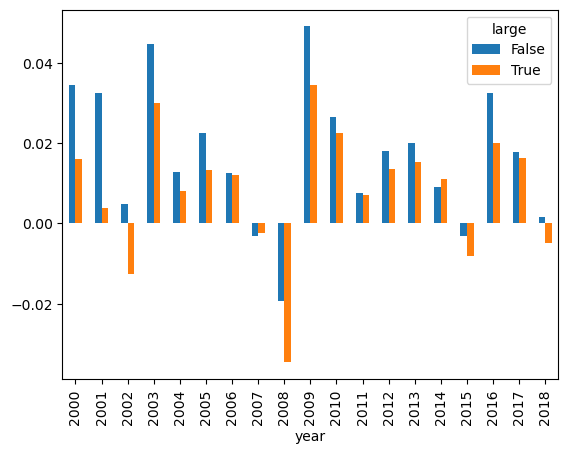

In [3]:
data_ml['year'] = data_ml.date.apply(lambda x: x.year)
data_ml['large'] = data_ml['Mkt_Cap_12M_Usd'] > data_ml.groupby('date')['Mkt_Cap_12M_Usd'].transform('median')
data_ml.groupby(['year','large'])['R1M_Usd'].mean().unstack('large').plot.bar()

In [4]:
datasets = pandas_datareader.famafrench.get_available_datasets()
print('No. of datasets:{0}'.format(len(datasets))) #check data set 
datasets[:5]

No. of datasets:297


['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

In [5]:
min_date = "1963-07-31"
max_date = "2020-05-28"
FF_factors = pandas_datareader.data.DataReader("F-F_Research_Data_5_Factors_2x3",'famafrench', start = min_date , end = max_date)            
FF_factors[0].index = FF_factors[0].index.map(lambda x: dt.strptime(str(x),'%Y-%m').replace(day = calendar.monthrange(x.year, x.month)[1])) 
FF_factors = FF_factors[0]
FF_factors = FF_factors.apply(lambda x: x/100)
FF_factors.index.name ='date' 
FF_factors.columns =[x.replace('-','_').upper() for x in FF_factors.columns]                                                                                             
FF_factors = FF_factors.drop(columns='RF')                                                                                            
FF_factors.head()

C:\Users\SE24171\AppData\Local\Temp\ipykernel_3684\2741765579.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF_factors = pandas_datareader.data.DataReader("F-F_Research_Data_5_Factors_2x3",'famafrench', start = min_date , end = max_date)
C:\Users\SE24171\AppData\Local\Temp\ipykernel_3684\2741765579.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF_factors = pandas_datareader.data.DataReader("F-F_Research_Data_5_Factors_2x3",'famafrench', start = min_date , end = max_date)


,MKT_RF,SMB,HML,RMW,CMA
date,,,,,
1963-07-31,-0.0039,-0.0041,-0.0097,0.0068,-0.0118
1963-08-31,0.0507,-0.0080,0.0180,0.0036,-0.0035
1963-09-30,-0.0157,-0.0052,0.0013,-0.0071,0.0029
1963-10-31,0.0253,-0.0139,-0.0010,0.0280,-0.0201
1963-11-30,-0.0085,-0.0088,0.0175,-0.0051,0.0224


<Axes: xlabel='year'>

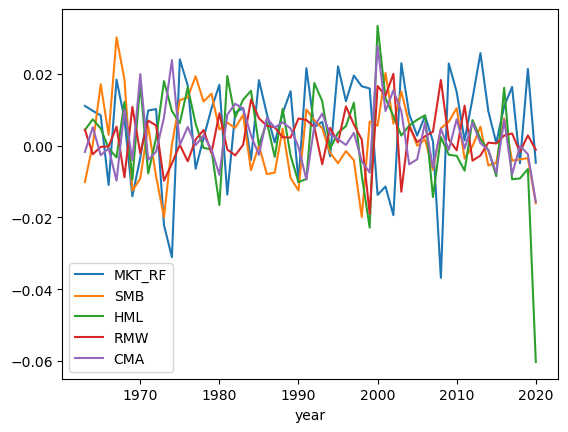

In [6]:
FF_factors['year'] = FF_factors.index.year
FF_factors.groupby('year').mean().plot()

In [7]:
nb_factors = 5  
data_FM = pd.merge(
    data_ml[['date', 'stock_id', 'R1M_Usd']].query("stock_id in @stock_ids_short"),
    FF_factors.reset_index(),
    on="date",
    how="left"
)
data_FM['R1M_Usd'] = data_FM.groupby('stock_id')['R1M_Usd'].shift(1)
data_FM.dropna(inplace=True)
data_FM_wide = data_FM.pivot(index='date', columns='stock_id', values='R1M_Usd')

models = {}
for stock in stock_ids_short:
    y = data_FM_wide[stock].dropna()
    X = FF_factors.loc[y.index, ["MKT_RF", "SMB", "HML", "RMW", "CMA"]]
    X = sm.add_constant(X)  
    model = sm.OLS(y, X).fit()
    models[stock] = model.params

betas = pd.DataFrame(models).T
betas.round(3)

,const,MKT_RF,SMB,HML,RMW,CMA
1,0.008,1.419,0.522,0.618,0.975,-0.361
3,-0.002,0.812,1.105,0.885,0.297,-0.554
4,0.005,0.363,0.306,-0.048,0.596,0.194
7,0.005,0.431,0.675,0.232,0.321,0.172
9,0.004,0.839,0.678,1.057,0.079,0.063
...,...,...,...,...,...,...
1204,-0.002,1.340,0.573,0.141,0.653,0.350
1208,0.007,1.461,0.430,0.170,0.678,0.208
1209,0.005,1.200,0.045,0.283,0.514,-0.344
1210,0.007,0.614,0.416,0.252,0.373,0.160


In [8]:
loadings = betas.drop(columns=['const']).copy()
FM_data = pd.concat([loadings, returns.T], axis=1)
FM_data.round(3)

,MKT_RF,SMB,HML,RMW,CMA,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,...,2018-03-31 00:00:00,2018-04-30 00:00:00,2018-05-31 00:00:00,2018-06-30 00:00:00,2018-07-31 00:00:00,2018-08-31 00:00:00,2018-09-30 00:00:00,2018-10-31 00:00:00,2018-11-30 00:00:00,2018-12-31 00:00:00
1,1.419,0.522,0.618,0.975,-0.361,-0.036,0.263,0.031,0.448,-0.097,...,0.173,-0.042,-0.038,0.000,-0.077,-0.002,-0.155,0.014,-0.110,0.082
3,0.812,1.105,0.885,0.297,-0.554,0.077,-0.024,0.018,0.027,0.050,...,-0.039,0.030,-0.028,-0.039,0.033,-0.049,-0.070,0.036,-0.070,0.030
4,0.363,0.306,-0.048,0.596,0.194,-0.016,0.000,0.153,-0.011,0.014,...,0.071,-0.024,0.059,0.029,-0.004,0.036,-0.025,0.000,-0.088,0.043
7,0.431,0.675,0.232,0.321,0.172,-0.009,0.027,0.000,-0.017,0.018,...,0.030,0.100,0.036,-0.005,0.022,-0.068,-0.052,0.007,-0.066,0.131
9,0.839,0.678,1.057,0.079,0.063,0.032,0.076,-0.025,-0.022,-0.121,...,0.046,0.047,0.000,0.064,-0.137,-0.028,-0.098,-0.018,-0.099,0.112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,1.340,0.573,0.141,0.653,0.350,0.080,0.161,-0.008,-0.114,-0.089,...,-0.038,-0.018,-0.036,0.061,0.046,0.005,-0.161,0.107,-0.050,0.147
1208,1.461,0.430,0.170,0.678,0.208,-0.372,0.143,0.057,0.070,-0.137,...,-0.018,-0.130,0.014,0.011,-0.054,0.126,-0.119,0.205,-0.189,0.227
1209,1.200,0.045,0.283,0.514,-0.344,-0.560,-0.102,0.144,-0.103,0.113,...,-0.052,0.066,-0.020,0.016,0.142,-0.009,0.000,0.076,-0.147,0.092
1210,0.614,0.416,0.252,0.373,0.160,-0.006,-0.057,0.085,0.073,0.016,...,0.020,0.063,0.051,-0.006,0.021,-0.011,0.028,0.063,-0.064,0.108


In [9]:
models = {}
for date in returns.index:
    y = FM_data[date].dropna()
    X = FM_data[["MKT_RF", "SMB", "HML", "RMW", "CMA"]].loc[y.index]
    X = sm.add_constant(X)  
    model = sm.OLS(y, X).fit()
    models[date] = model.params
    

gammas = pd.DataFrame(models).T

print(gammas.round(3))

            const  MKT_RF    SMB    HML    RMW    CMA
2000-01-31 -0.011   0.041  0.223 -0.143 -0.275  0.031
2000-02-29  0.014   0.075 -0.133  0.052  0.085 -0.035
2000-03-31  0.004  -0.009 -0.013  0.049  0.039  0.050
2000-04-30  0.124  -0.147 -0.094  0.156  0.076 -0.016
2000-05-31  0.052  -0.011  0.074 -0.095 -0.095 -0.056
...           ...     ...    ...    ...    ...    ...
2018-08-31 -0.004  -0.002 -0.022 -0.009  0.017  0.008
2018-09-30 -0.023  -0.051 -0.022  0.007  0.012  0.008
2018-10-31  0.036  -0.003 -0.009  0.001 -0.010  0.012
2018-11-30  0.080  -0.152 -0.016  0.001 -0.030 -0.007
2018-12-31  0.029   0.085  0.015 -0.033 -0.008 -0.056

[228 rows x 6 columns]


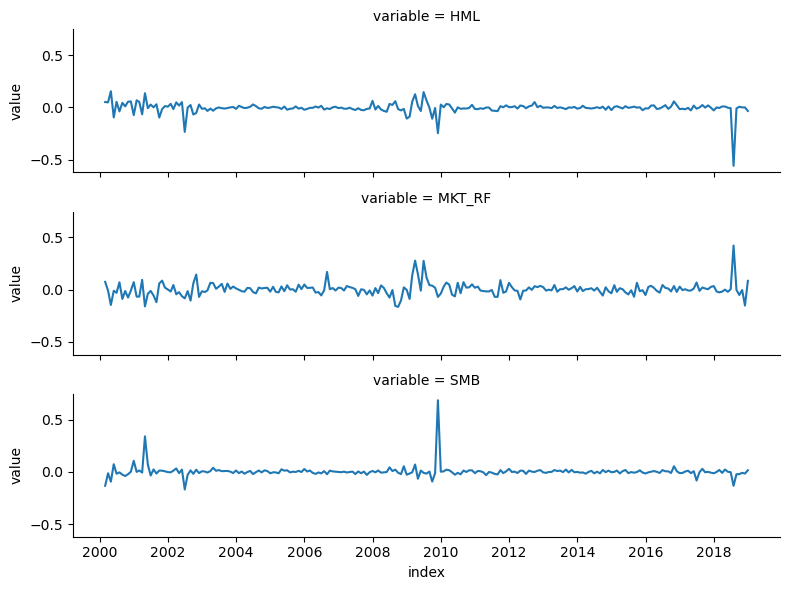

In [10]:
gammas_filtered = gammas.iloc[1:].copy()
gammas_filtered = gammas_filtered[['HML', 'MKT_RF', 'SMB']]

# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 6), sharex=True)
# for i, col in enumerate(gammas_filtered.columns):  # 'date'를 제외한 컬럼들
#     gammas[[col]].plot(ax=axes[i])

g = sns.FacetGrid(pd.melt(gammas_filtered.reset_index(), id_vars='index'), col="variable", 
                  col_wrap=1, sharey=True, aspect=4,height=2) 
g.map_dataframe(sns.lineplot, x="index", y="value")



In [11]:
# factors = ["MKT_RF", "SMB", "HML", "RMW", "CMA"]

# models = []
# for i, factor in enumerate(factors):
#     formula = f"{factor} ~ MKT_RF + SMB + HML + RMW + CMA - {factor}"  
#     model = smf.ols(formula, data=FF_factors).fit()  
#     intercept = model.params["Intercept"]  
#     p_value = model.pvalues["Intercept"]  
#     models.append([intercept, p_value])

# alphas = pd.DataFrame(models, index=factors, columns=["Estimate", "p-value"])
# alphas.round(3)

In [12]:
factors = ["MKT_RF", "SMB", "HML", "RMW", "CMA"]

models = {}
for factor in factors:
    y = FF_factors[factor]
    X = FF_factors.drop(columns=[factor,'year']).copy()
    X = sm.add_constant(X)  
    model = sm.OLS(y, X).fit()  
    models[factor] = model.params

alphas = pd.DataFrame(models).T['const']
alphas.round(3)

MKT_RF    0.008
SMB       0.003
HML      -0.001
RMW       0.004
CMA       0.003
Name: const, dtype: float64

In [13]:
models = {}
p_values = {}
for factor in factors:
    y = FF_factors[factor]
    X = FF_factors.drop(columns=[factor,'year']).copy()
    X = sm.add_constant(X)  
    model=sm.OLS(y,X).fit()
    models[factor] = model.params
    p_values[factor] = model.pvalues
results = pd.DataFrame(models).T[['const','MKT_RF','SMB','HML','RMW','CMA']].round(3)
result_p = pd.DataFrame(p_values).T.applymap(lambda x: " (***)" if x<0.001 else 
                                            " (**)"  if x<0.01  else
                                            " (*)"   if x<0.05 else "")
(results.astype('str') + result_p)[['const','MKT_RF','SMB','HML','RMW','CMA']]

C:\Users\SE24171\AppData\Local\Temp\ipykernel_3684\3951123532.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result_p = pd.DataFrame(p_values).T.applymap(lambda x: " (***)" if x<0.001 else


,const,MKT_RF,SMB,HML,RMW,CMA
MKT_RF,0.008 (***),nan,0.278 (***),0.162 (*),-0.343 (***),-0.994 (***)
SMB,0.003 (*),0.139 (***),nan,0.112 (*),-0.43 (***),-0.166 (*)
HML,-0.001,0.046 (*),0.063 (*),nan,0.189 (***),1.04 (***)
RMW,0.004 (***),-0.089 (***),-0.222 (***),0.173 (***),nan,-0.324 (***)
CMA,0.003 (***),-0.118 (***),-0.039 (*),0.435 (***),-0.148 (***),nan


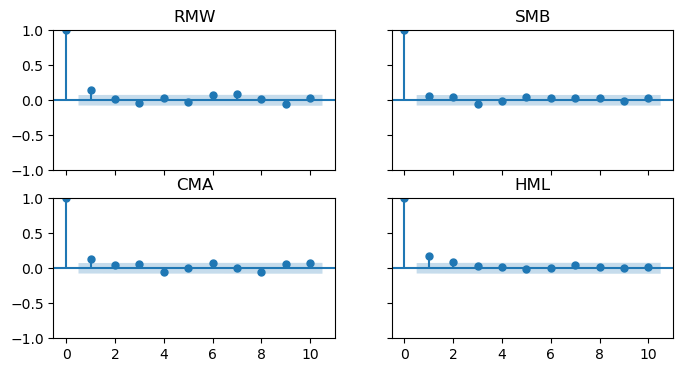

In [14]:
fig, ax = plt.subplots(2,2,figsize=(8,4),sharex='all', sharey='all') # how to
sm.graphics.tsa.plot_acf(FF_factors.RMW, lags=10, ax=ax[0,0],title='RMW') # chek fo rthe name 
sm.graphics.tsa.plot_acf(FF_factors.CMA, lags=10, ax=ax[1,0],title='CMA')
sm.graphics.tsa.plot_acf(FF_factors.SMB, lags=10, ax=ax[0,1],title='SMB')
sm.graphics.tsa.plot_acf(FF_factors.HML, lags=10, ax=ax[1,1],title='HML')
plt.show()